In [1]:
import os, sys, re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from os.path import join, exists
from scipy.interpolate import make_interp_spline, BSpline
root_data_dir = join("/home", "paul", "gp-data")

In [2]:
def average_df(df):
    exp_list = get_expname_and_number(list(df["expname"]))
    categories = ["accuracy_3s", "accuracy_10s", "accuracy_30s",
                     "c_primary_3s", "c_primary_10s", "c_primary_30s"]
    avg_categories = get_mean_std_category_list(categories)
    df_results = pd.DataFrame(columns=["expname", "train_length", "enroll_length"] + avg_categories)
    for i, exps in enumerate(exp_list):
        expname = exps[0]
        tr_length, en_length = get_lengths_from_expname(expname)
        df_results.loc[i] = [expname, tr_length, en_length, -1, -1, -1, -1, -1, -1, 
                             -1, -1, -1, -1, -1, -1]
        for category in categories:
            indices = []
            for exp in exps:
                idx = df[df["expname"] == exp].index[0]
                indices.append(idx)
            vals = list(df[category].loc[indices])
            vals = list(extract_nums(vals))
            mean = np.mean(vals)
            std = np.std(vals)
            df_results["mean_" + category].loc[i] = mean
            df_results["std_" + category].loc[i] = std
    df_results = df_results.sort_values("enroll_length")
    df_results = df_results.sort_values("train_length")
    df_results = df_results.reset_index(drop=True)
    return df_results
            
def extract_nums(vals):
    for item in vals:
        try:
            yield float(item)
        except ValueError:
            pass
        
def get_lengths_from_expname(expname):
    if "baseline" in expname:
        return "all", "all"
    if expname[-2] == "_":
        string = expname[:-2]
    else:
        string = expname
    entry = string.split("_")
    tr_length = int(entry[2])
    en_length = int(entry[4])
    return tr_length, en_length
        
def get_mean_std_category_list(categories):
    list_out = []
    for cat in categories:
        list_out.append("mean_" + cat)
        list_out.append("std_" + cat)
    return list_out
    
def get_expname_and_number(expnames):
    exp_list = []
    found_names = []
    counts = []
    for exp in expnames:
        if exp[-2] == "_":
            name = exp[:-2]
        else:
            name = exp
        if name not in found_names:
            found_names.append(name)
            counts.append(1)
        else:
            idx = found_names.index(name)
            counts[idx] += 1
    for idx, name in enumerate(found_names):
        count = counts[idx]
        name_list = [name]
        if count > 1:
            for i in range(2, count + 1):
                new_name = name + "_" + str(i)
                name_list.append(new_name)
        exp_list.append(name_list)
    return exp_list

def get_mean_info_str(category, seconds):
    return "mean_" + category + "_" + str(seconds) + "s"

def get_square_df(df, category, seconds):
    mean_cols = ["train_length", "enroll_length", 
                get_mean_info_str(category, seconds)]
    mean_df = df[mean_cols]
    mean_df = mean_df.pivot(index="train_length", 
                            columns="enroll_length")
    mean_df = mean_df.sort_index(ascending=False)
    return mean_df

def find_min_max(dfs):
    min_val = 99999
    max_val = -1
    for df in dfs:
        min_df = min(df.min())
        if min_df < min_val:
            min_val = min_df
        max_df = max(df.max())
        if max_df > max_val:
            max_val = max_df
    return min_val, max_val

def plot_lre_heatmap(df, category, seconds, savename=None, cmap="magma", 
                     precision='.3f', size=(5,4)):
    if category not in ["accuracy", "c_primary"]:
        print("Invalid category given: {}" + 
              "\nShould be \"accuracy\" or \"c_primary\""
              .format(category))
        return
    if seconds not in [3, 10, 30]:
        print("Invalid seconds length given: {}" +
              "\nShould be an integer of 3, 10 or 30".format(seconds))
        return
    mean_info = get_mean_info_str(category, seconds)
    std_info = "std_" + category + "_" + str(seconds) + "s"
    
    # Reverse colours if c_primary to look similar to accs
    if category == "c_primary":
        cmap=cmap + "_r"
    
    mean_cols = ["train_length", "enroll_length", mean_info]
    std_cols = ["train_length", "enroll_length", std_info]
    mean_df = df[mean_cols]
    std_df = df[std_cols]
    
    mean_df = mean_df.pivot(index="train_length", 
                            columns="enroll_length")
    mean_df = mean_df.sort_index(ascending=False)
    plt.figure(figsize=size)
    sns.set(font_scale=1.1)
    sns.heatmap(mean_df, annot=True, cmap=cmap, fmt=precision)
    tick_pos = [0.5, 1.5, 2.5, 3.5]
    plt.xlabel("Enrollment data (s)")
    plt.xticks(tick_pos, labels=["500", "1000", "5000", "10000"], 
               rotation=0)
    plt.ylabel("Training data (s)")
    plt.tight_layout()
    if savename is not None:
        plt.savefig(savename + ".pdf", bbox_inches="tight")

def plot_multiple_heatmaps(df, category, savename=None, cmap="magma", 
                           precision='.3f', size=(12,4), compare=True):
    mean_df_3 = get_square_df(df, category, 3)
    mean_df_10 = get_square_df(df, category, 10)
    mean_df_30 = get_square_df(df, category, 30)
    if compare:
        vmin,vmax = find_min_max([mean_df_3, mean_df_10, mean_df_30])
    else:
        vmin = None
        vmax = None
    # Reverse colours if c_primary to look similar to accs
    if category == "c_primary":
        cmap=cmap + "_r"
    
    f,(ax1, ax2, ax3, axcb) = plt.subplots(1, 4,
                              gridspec_kw={"width_ratios": [1,1,1,0.08]},
                              figsize=size)
    ax1.get_shared_y_axes().join(ax2, ax3)
    sns.set(font_scale=1)
    g1 = sns.heatmap(mean_df_3, cmap=cmap, annot=True, fmt=precision,
                     cbar=False, ax=ax1, vmin=vmin, vmax=vmax)
    g1.set_ylabel("Training data (s)")
    g1.set_xlabel("")
    g1.set_title("3s evaluation")
    g2 = sns.heatmap(mean_df_10, cmap=cmap, annot=True, fmt=precision,
                     cbar=False, ax=ax2, vmin=vmin, vmax=vmax)
    g2.set_ylabel("")
    g2.set_xlabel("Enrollment data (s)")
    g2.set_title("10s evaluation")
    g2.set_yticks([])
    g3 = sns.heatmap(mean_df_30, cmap=cmap, annot=True, fmt=precision,
                     ax=ax3, cbar_ax=axcb, vmin=vmin, vmax=vmax)
    g3.set_ylabel("")
    g3.set_xlabel("")
    g3.set_title("30s evaluation")
    g3.set_yticks([])
    for ax in [g1,g2,g3]:
        labels = ["500", "1000", "5000", "10000"]
        ax.set_xticklabels(labels,rotation=0)
        
    if savename is not None:
        plt.tight_layout()
        plt.savefig(savename + ".pdf", bbox_inches="tight")
        
def get_nnet_df(expname):
    exp_path = join(root_data_dir, expname, 
                    "nnet", "accuracy.output.report")
    if not exists(exp_path):
        print("Path not found at {}".format(exp_path))
        return None
    nnet_df = pd.read_csv(exp_path, delim_whitespace=True)
    nnet_df.drop(nnet_df.tail(1).index,inplace=True)
    nnet_df.drop(["duration", "difference"],axis=1, inplace=True)
    nnet_df = nnet_df.apply(pd.to_numeric)
    nnet_df.rename(columns={"%Iter":"iteration",
                            "train_objective": "train_acc",
                            "valid_objective": "valid_acc"},inplace=True)
    return nnet_df

def get_col_names(category, length):
    acc = category + "_acc"
    if length == 3:
        return [acc, acc + "_x", acc + "_y"]
    else:
        return [acc]

def get_average_nnet_df(exps):
    all_dfs = []
    for exp in exps:
        all_dfs.append(get_nnet_df(exp))
    full_df = all_dfs[0]
    if len(all_dfs) > 1:
        for df in all_dfs[1:]:
            full_df = pd.merge(full_df, df, on="iteration", how="inner")
    for category in ["train", "valid"]:
        cols = get_col_names(category, len(exps))
        full_df["mean_" + category + "_acc"] = full_df[cols].mean(axis=1)
        full_df["min_" + category + "_acc"] = full_df[cols].min(axis=1)
        full_df["max_" + category + "_acc"] = full_df[cols].max(axis=1)
        if len(all_dfs) > 1:
            full_df["std_" + category + "_acc"] = full_df[cols].std(axis=1)
        else:
            full_df["std_" + category + "_acc"] = float(0)
        full_df.drop(cols, axis=1, inplace=True)
    full_df["iteration"] += 1
    full_df.loc[-1] = [0, 0, 0, 0, 0, 0, 0, 0, 0]
    full_df.index = full_df.index + 1
    full_df.sort_index(inplace=True)
    return full_df

def get_vals(exp_df, category):
    mean_vals = exp_df["mean_" + category + "_acc"]
    std_vals = exp_df["std_" + category + "_acc"]
    max_vals = exp_df["max_" + category + "_acc"]
    min_vals = exp_df["min_" + category + "_acc"]
    return mean_vals, std_vals, max_vals, min_vals

def get_ylabel(category):
    if category == "valid":
        return "Mean validation accuracy (%)"
    elif category == "train":
        return "Mean training accuracy (%)"
    else:
        print("Unknown category: {}".format(category))
        return category

def get_all_nnet_dfs(lre_df, baseline_df):
    exp_list = get_expname_and_number(list(lre_df["expname"]))
    baseline_list = get_expname_and_number(list(baseline_df["expname"]))
    for idx, exps in enumerate(exp_list):
        #print(exps)
        exp = exps[0]
        if "en_500" in exp and not "en_5000" in exp:
            if "tr_10000" in exp:
                nnet_10000_df = get_average_nnet_df(exps)
                nnet_10000_df.name = "10000"
            elif "tr_5000" in exp:
                nnet_5000_df = get_average_nnet_df(exps)
                nnet_5000_df.name = "5000"
            elif "tr_1000" in exp:
                nnet_1000_df = get_average_nnet_df(exps)
                nnet_1000_df.name = "1000"
            elif "tr_500" in exp:
                nnet_500_df = get_average_nnet_df(exps)
                nnet_500_df.name = "500"
    for exps in baseline_list:
        baseline_df = get_average_nnet_df(exps)
        baseline_df.name = "Baseline"
    return [baseline_df, nnet_500_df, nnet_1000_df, nnet_5000_df, nnet_10000_df]
        
def plot_multiple_exp_line(exp_dfs, category, legend_loc="best", size=(10,6), show_err=True,
                      alpha=0.1, ylim=None, xlim=None, savename=None, smooth=False):
    colours = sns.color_palette()
    max_colours = len(colours)
    max_iterations = 0
    plt.figure(figsize=size)
    for idx, exp_df in enumerate(exp_dfs):
        iterations = exp_df["iteration"]
        if len(iterations) + 1 > max_iterations:
            max_iterations = len(iterations) + 1
        exp_label=exp_df.name
        mean_vals, std_vals, _, _ = get_vals(exp_df, category)
        colour_idx = idx % max_colours
        if not smooth:
            plt.plot(iterations, mean_vals, '-', color=colours[colour_idx], label=exp_label)
        else:
            xnew = np.linspace(0, iterations.max(), 100)
            spl = make_interp_spline(iterations, mean_vals, k=3)
            power_smooth = spl(xnew)
            plt.plot(xnew, power_smooth, '-', color=colours[colour_idx], label=exp_label)
        if show_err:
            plt.fill_between(iterations, mean_vals - std_vals, mean_vals + std_vals,
                            color=colours[colour_idx], alpha=alpha)
    ax = plt.gca()
    ax.set_facecolor("w")
    ax.spines['bottom'].set_color("black")
    ax.spines['left'].set_color("black")
    ax.set_ylabel(get_ylabel(category))
    ax.set_xlabel("Iterations")
    if xlim is not None:
        ax.set_xlim(xlim)
    else:
        ax.set_xlim(0, max_iterations)
    if ylim is not None:
        ax.set_ylim(ylim)
    else:
        ax.set_ylim(bottom=0)
    plt.legend(loc=legend_loc, title="Training data (s)", facecolor="w")
    plt.tight_layout()
    if savename is not None:
        plt.savefig(savename + ".pdf", bbox_inches="tight")
    plt.show()

/home/paul/miniconda3/envs/lid/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


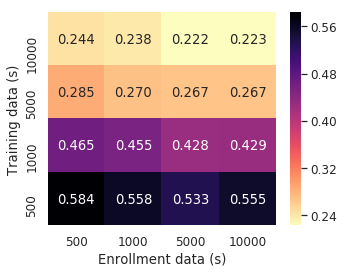

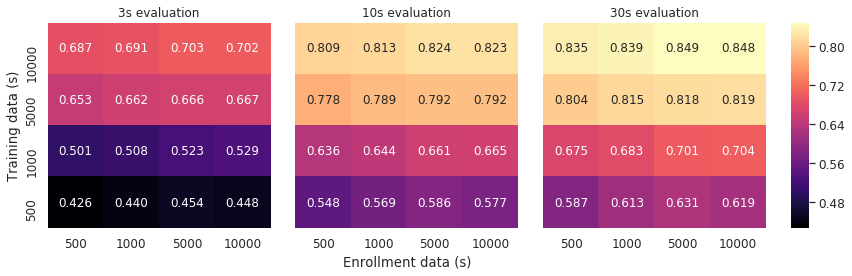

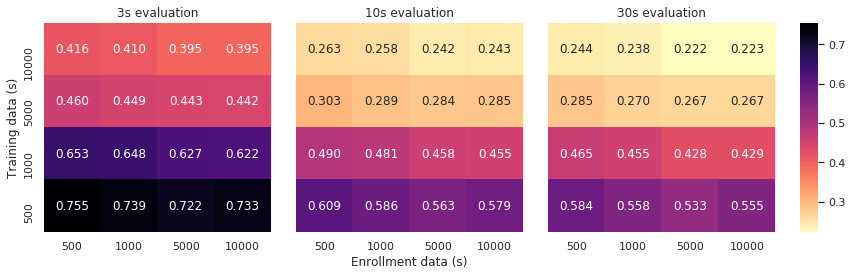

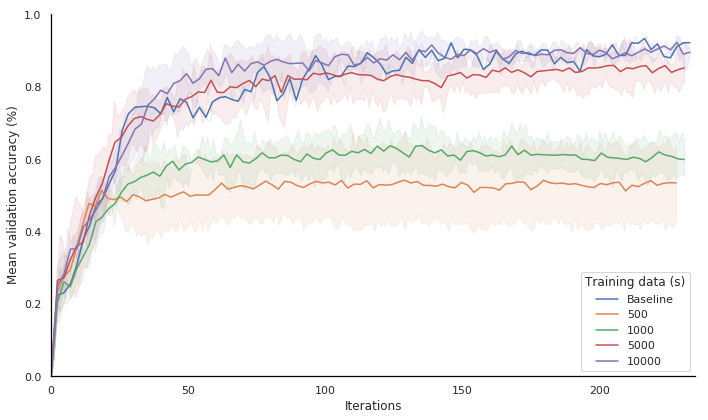

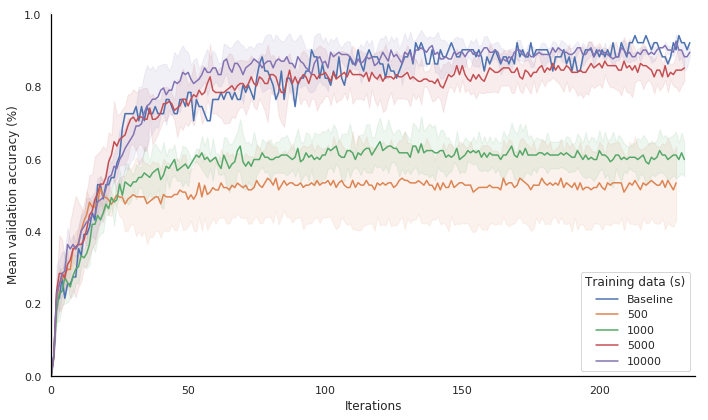

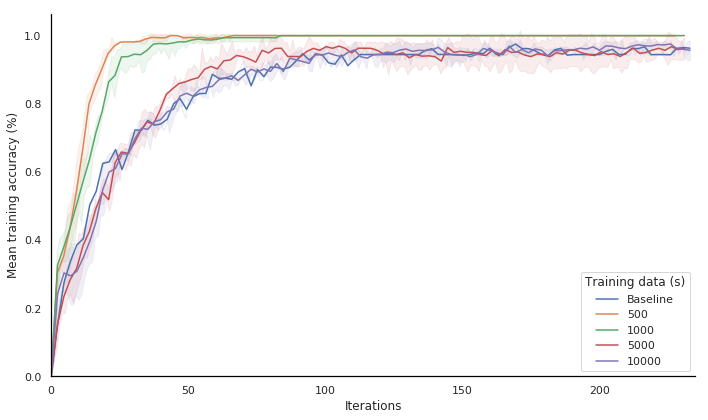

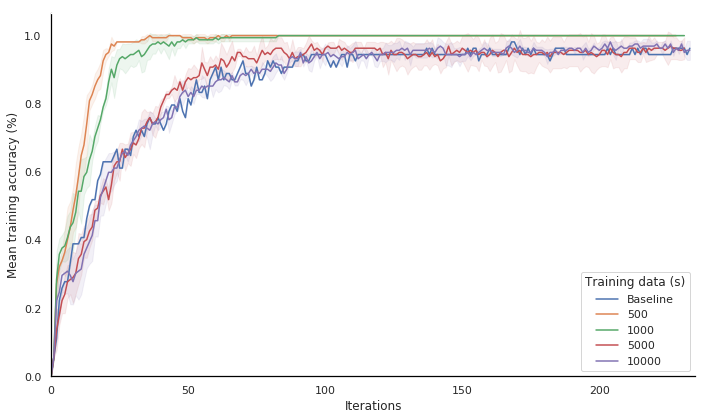

In [3]:
all_df = pd.read_csv(join(os.getcwd(), "finished_expts", "lre_summary.csv"))

# Filter expts from baseline
baseline_df = all_df[all_df.training_length == "all"]
lre_df = all_df[all_df.training_length != "all"]

avg_baseline = average_df(baseline_df)
avg_lre = average_df(lre_df)
avg_lre = avg_lre.drop("expname", axis=1)
avg_lre = avg_lre.apply(pd.to_numeric)

#plot_lre_heatmap(avg_lre, "c_primary", 30, cmap="magma")
#plot_multiple_heatmaps(avg_lre, "accuracy", savename="all_lre_accs")
#plot_multiple_heatmaps(avg_lre, "c_primary", savename="all_lre_c_primary")

exp_dfs = get_all_nnet_dfs(lre_df, baseline_df)

#plot_multiple_exp_line(exp_dfs, "valid", smooth=True, savename="lre_valid_nnet_smooth")  
#plot_multiple_exp_line(exp_dfs, "valid", smooth=False, savename="lre_valid_nnet_rough")
#plot_multiple_exp_line(exp_dfs, "train", smooth=True, savename="lre_train_nnet_smooth")
#plot_multiple_exp_line(exp_dfs, "train", smooth=False, savename="lre_train_nnet_rough")